In [208]:
library(SummarizedExperiment)
library(VariantAnnotation)
library(Rtsne)
library(ggplot2)
library(gplots)
library(dplyr)
library(irlba)
library(RColorBrewer)

In [32]:
vcf <- readRDS('Map_K10_VBC_CLI.whitelist.noindel.rds')
meta <- read.csv('MetaDATAJohnes2.csv', header = TRUE)
rownames(meta) <- meta$SeqID
meta <- meta[colnames(vcf), ]
colData(vcf) <- DataFrame(meta)
colData(vcf)

DataFrame with 525 rows and 12 columns
          SeqID  SampleID     CowID    State      Farm          Type       Mix
       <factor> <integer> <integer> <factor> <integer>      <factor> <integer>
MAP129   MAP129       129      1283       NY         9        tissue         1
MAP381   MAP381       381      9999       VT        11 environmental         0
MAP350   MAP350       350       228       PA        10        tissue         0
MAP022   MAP022        22      1085       NY         9         fecal         0
MAP514   MAP514       514       506       VT        11         fecal         0
...         ...       ...       ...      ...       ...           ...       ...
MAP439   MAP439       439       491       VT        11        tissue         0
MAP380   MAP380       380       136       VT        11         fecal         0
MAP191   MAP191       191      1255       NY         9         fecal         0
MAP006   MAP006         6       693       NY         9         fecal         1
MAP775   MAP7

In [34]:
table(colData(vcf)$State, colData(vcf)$Date)

    
     2004 2005 2006 2007 2008 2009 999 unknown
  MN    0    5   39   20   22   16   3       1
  NY   28   21   70   40   20    0   0       0
  PA   13    6   15    3    3    9   0       0
  VT    6   40   50   38   37   20   0       0

In [47]:
# remove the sample with no date information
exclude <- colData(vcf)$Date == 999 | colData(vcf)$Date == 'unknown'
vcf <- vcf[, !exclude]
colData(vcf)$Date <- factor(colData(vcf)$Date, c(2004:2009))
table(colData(vcf)$State, colData(vcf)$Date)

    
     2004 2005 2006 2007 2008 2009
  MN    0    5   39   20   22   16
  NY   28   21   70   40   20    0
  PA   13    6   15    3    3    9
  VT    6   40   50   38   37   20

In [249]:
GT <- geno(vcf)$GT
table(c(GT))
GT[GT %in% c('.')] <- '0/0' # missing values
GT[GT%in% c('0/2', '0/3')] <- '0/1'
GT_freq <- apply(GT, 1, function(x) x %>% factor(c('0/0', '0/1', '1/1')) %>% table()) %>% t()
valid <- rowSums(GT_freq > 1) >= 2 # only include genotype that have alternative allels in at least two samples
GT <- GT[valid, ]
vcf <- vcf[valid]
GT %>% head()
dim(GT)


     .    0/0    0/1    0/2    0/3    1/1 
   127 242044   3396    129      7   3856 

,MAP129,MAP381,MAP350,MAP022,MAP514,MAP545,MAP401,MAP727,MAP153,MAP351,...,MAP517,MAP137,MAP944,MAP563,MAP143,MAP439,MAP380,MAP191,MAP006,MAP775
Map_K10_VBC_CLI:2683_C/T,0/0,0/0,0/0,0/0,0/0,0/1,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
Map_K10_VBC_CLI:2702_A/C,0/1,0/0,1/1,0/0,0/0,0/0,0/0,0/0,0/0,1/1,...,1/1,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
Map_K10_VBC_CLI:3367_C/T,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,...,1/1,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
Map_K10_VBC_CLI:3742_C/A,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
Map_K10_VBC_CLI:3944_C/T,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
Map_K10_VBC_CLI:5726_C/T,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/1,0/0


[1] 479 521

### temporal non-negative matrix factorization (NMF)

In [329]:
set.seed(1)
K <- 7 # number of strains
epochs <- 2000
beta <- 100
stages <- colData(vcf)$Date
n_stages <- nlevels(stages)
N <- nrow(GT) # number of SNPs
M <- table(stages) # number of samples at each stage
states <- unlist(lapply(seq_len(n_stages), function(s) colData(vcf)$State[stages == levels(stages)[s]]))
gt2num <- c('0/0' = 0, '0/1' = 0.5, '1/1' = 1)
X <- lapply(seq_len(n_stages), function(s){
  gt2num[GT[, stages == levels(stages)[s]]] %>%
  matrix(nrow = N, ncol = M[s])
})
# initialize the strain panel for each group (each year)
U <- lapply(seq_len(n_stages), function(s) runif(N * K) %>% matrix(nrow = N, ncol = K))
# initlize the composition matrix for each sample
V <- lapply(seq_len(n_stages), function(s) runif(K * M[s]) %>% matrix(nrow = K, ncol = M[s]))

In [330]:
for (epoch in seq_len(epochs)){
  for (s in seq_len(n_stages)){
    if (s == n_stages){
      U[[s]] <- U[[s]] * (
        (X[[s]] %*% t(V[[s]]) + 1e-3) / 
        (U[[s]] %*% (V[[s]] %*% t(V[[s]])) + 1e-3)
      )
    }else{
      U[[s]] <- U[[s]] * (
        (X[[s]] %*% t(V[[s]]) + beta * U[[s + 1]] + 1e-3) / 
        (U[[s]] %*% (V[[s]] %*% t(V[[s]])) + beta * U[[s]] + 1e-3)
      )
    }
    V[[s]] <- V[[s]] * (
      (t(U[[s]]) %*% X[[s]] + 1e-3) / 
      (t(U[[s]]) %*% U[[s]] %*% V[[s]] + 1e-3)
    )
  }
  loss_reconstruct <- Reduce(
    '+', 
    lapply(seq_len(n_stages), function(s) norm(X[[s]] - U[[s]] %*% V[[s]], 'F')^2)
  )
  loss_temporal <- Reduce(
    '+', 
    lapply(seq_len(n_stages - 1), function(s) norm(U[[s]] - U[[s + 1]], 'F')^2)
  )
  if (epoch %% 500 == 0){
    sprintf(
      'iter=%4.d/%4.d | beta=%7.3f | loss_reconstruct=%13.7f | loss_temporal=%13.7f | total_loss=%13.7f\n', 
      epoch,
      epochs, 
      beta,
      loss_reconstruct,
      beta * loss_temporal,
      loss_reconstruct + beta * loss_temporal
    ) %>% message()
  }
}

iter= 500/2000 | beta=100.000 | loss_reconstruct= 1241.0230625 | loss_temporal=   96.9216289 | total_loss= 1337.9446914

iter=1000/2000 | beta=100.000 | loss_reconstruct= 1240.9975244 | loss_temporal=   96.8506086 | total_loss= 1337.8481330

iter=1500/2000 | beta=100.000 | loss_reconstruct= 1240.9837047 | loss_temporal=   96.8516231 | total_loss= 1337.8353278

iter=2000/2000 | beta=100.000 | loss_reconstruct= 1240.9903013 | loss_temporal=   96.8507402 | total_loss= 1337.8410415



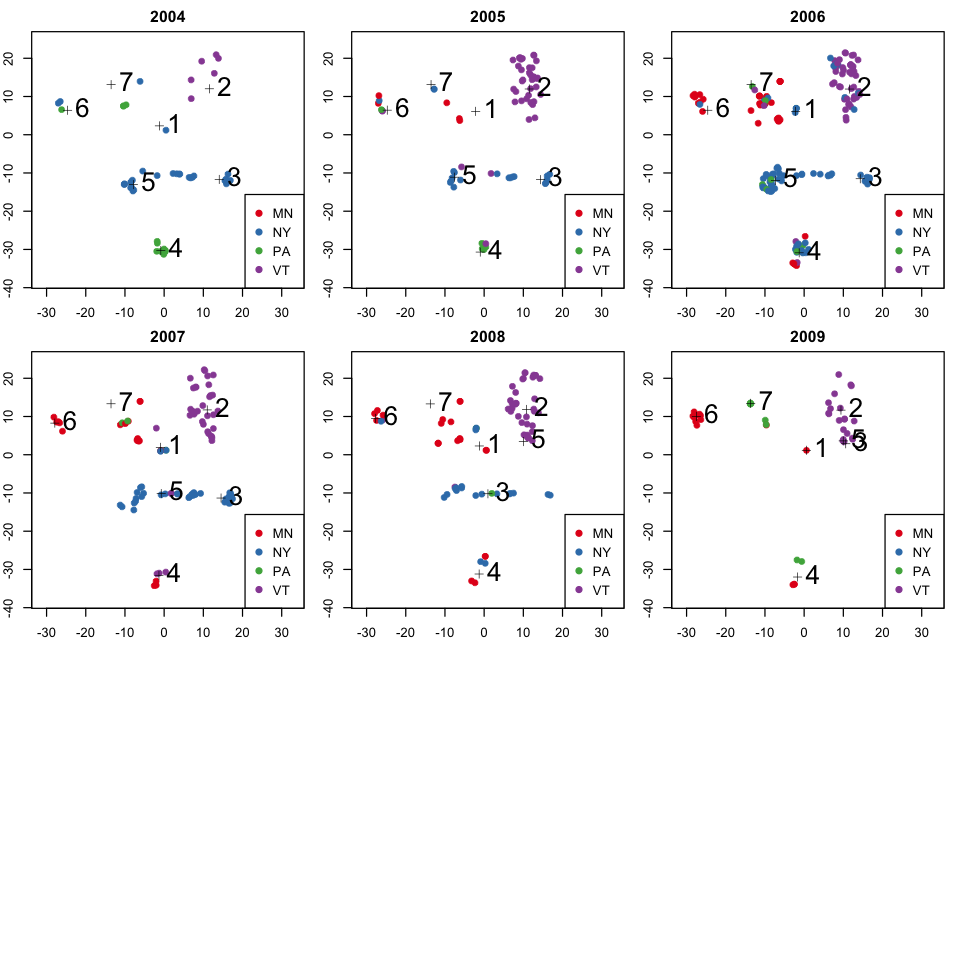

In [343]:
Xb <- do.call('cbind', X)
Ub <- do.call('cbind', lapply(U, function(u) u %*% Diagonal(x = 1 / colMaxs(u)) %>% as.matrix()))
Z <- cbind(Xb, Ub)
v <- irlba(Z, nu = 1, nv = 10)$v                           
bg_X <- brewer.pal(4, 'Set1')[states %>% factor() %>% as.numeric()]
bg_U <- rep('black', ncol(Ub))
pch <- rep(c(21, 3), c(ncol(Xb), ncol(Ub)))
bg <- c(bg_X, bg_U)
groups <- c(
  rep(levels(stages), sapply(X, ncol)),
  rep(levels(stages), sapply(U, ncol))
)
meta_genotype <- rep(c(FALSE, TRUE), c(ncol(Xb), ncol(Ub)))
set.seed(1)
y_tsne <- Rtsne(v)$Y

options(repr.plot.width=8, repr.plot.height=8)
par(mfrow = c(3, 3), mar = c(2, 2, 2, 1))    
xlim <- c(min(y_tsne[, 1]) * 1.1, max(y_tsne[, 1]) * 1.9)
ylim <- c(min(y_tsne[, 2]) * 1.1, max(y_tsne[, 2]) * 1.1)
for (year in levels(stages)){                             
  i <- groups == year
  plot(y_tsne[i, ], pch = pch[i], bg = bg[i], col = bg[i], cex = 1, main = year, xlab = '', ylab = '', lwd = 0.5, xlim = xlim, ylim = ylim)
  text(y_tsne[i & meta_genotype, ], labels = 1:K, cex = 2, pos = 4)
  legend('bottomright', legend = levels(states), pt.bg = brewer.pal(4, 'Set1'), col = brewer.pal(4, 'Set1'), pch = 21)
}